# Daily Panel FF5 Regressions by IV-Skew Quintile

Extends the single-firm analysis to a universe of tickers using the daily FF5 dataset.


In [1]:
import pandas as pd
import polars as pl
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", None)
print("✓ Libraries ready")


✓ Libraries ready


In [10]:
DATA_PATH = Path("processed_data/daily_merged_with_ff5.parquet")
MIN_OBS_PER_QUINTILE = 30
USE_ALL_TICKERS = True
TOP_N_TICKERS = 50

daily_df = pl.read_parquet(DATA_PATH)
print(f"Loaded {daily_df.shape[0]:,} rows, {daily_df['TICKER'].n_unique()} tickers")


Loaded 1,636,688 rows, 4213 tickers


In [11]:
base_pl = daily_df.select([
    "secid", "TICKER", "iv_date", "IV_skew", "excess_return",
    "Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"
])

universe_df = (
    base_pl.group_by("TICKER")
    .agg(pl.len().alias("n_obs"))
    .sort("TICKER")
)
if not USE_ALL_TICKERS:
    universe_df = universe_df.sort("n_obs", descending=True).head(TOP_N_TICKERS)

universe_pd = universe_df.to_pandas()
print(f"Using {len(universe_pd)} tickers for panel regressions")
universe_pd.head(10)


Using 4213 tickers for panel regressions


,TICKER,n_obs
0,A,923
1,AA,922
2,AABA,139
3,AAC,10
4,AACQ,55
5,AADI,68
6,AAIC,2
7,AAL,924
8,AAN,678
9,AAOI,653


In [12]:
def star_from_p(pval: float) -> str:
    if np.isnan(pval):
        return ""
    if pval < 0.01:
        return "***"
    if pval < 0.05:
        return "**"
    if pval < 0.10:
        return "*"
    return ""


def run_ff5(subset: pd.DataFrame):
    X = subset[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]
    X = sm.add_constant(X)
    y = subset["excess_return"]
    model = sm.OLS(y, X).fit()
    robust = model.get_robustcov_results(cov_type="HC1")
    robust.rsq = model.rsquared
    return robust


def prep_ticker_frame(ticker: str) -> pd.DataFrame:
    ticker_pl = (
        base_pl
        .filter(pl.col("TICKER") == ticker)
        .drop_nulls()
        .sort("iv_date")
    )
    if ticker_pl.height == 0:
        return pd.DataFrame()
    df = ticker_pl.to_pandas()
    df["iv_date"] = pd.to_datetime(df["iv_date"])
    df["iv_quintile"] = (
        pd.qcut(df["IV_skew"], q=5, labels=False, duplicates="drop")
        .astype("float")
        .add(1)
    )
    return df


In [13]:
def compute_quintile_results(df: pd.DataFrame, ticker: str) -> list[dict]:
    rows = []
    if df.empty:
        return rows
    for quint in sorted(df["iv_quintile"].dropna().unique()):
        bucket = df[df["iv_quintile"] == quint]
        if len(bucket) < MIN_OBS_PER_QUINTILE:
            continue
        model = run_ff5(bucket)
        params = pd.Series(model.params, index=model.model.exog_names)
        pvals = pd.Series(model.pvalues, index=model.model.exog_names)
        rows.append({
            "ticker": ticker,
            "quintile": int(quint),
            "n_obs": len(bucket),
            "alpha": params["const"],
            "alpha_p": pvals["const"],
            "alpha_sig": star_from_p(pvals["const"]),
            "r_squared": getattr(model, "rsq", np.nan)
        })
    return rows


In [14]:
panel_rows = []
for ticker in universe_pd["TICKER"]:
    df = prep_ticker_frame(ticker)
    if df.empty:
        print(f"{ticker}: no usable rows (skipped)")
        continue
    rows = compute_quintile_results(df, ticker)
    panel_rows.extend(rows)
    print(f"{ticker}: {len(rows)} quintile regressions")

panel_results = pd.DataFrame(panel_rows)
print(f"\nTotal regressions run: {len(panel_results):,}")
panel_results.head()


A: 5 quintile regressions
AA: 5 quintile regressions
AABA: 0 quintile regressions
AAC: 0 quintile regressions
AACQ: 0 quintile regressions
AADI: 0 quintile regressions
AAIC: 0 quintile regressions
AAL: 5 quintile regressions
AAN: 5 quintile regressions
AAOI: 5 quintile regressions
AAON: 5 quintile regressions
AAP: 5 quintile regressions
AAPL: 5 quintile regressions
AAWW: 5 quintile regressions
AAXN: 5 quintile regressions
ABBV: 5 quintile regressions
ABC: 5 quintile regressions
ABCB: 5 quintile regressions
ABEO: 0 quintile regressions
ABG: 5 quintile regressions
ABIO: 0 quintile regressions
ABM: 5 quintile regressions
ABMD: 5 quintile regressions
ABNB: 5 quintile regressions
ABOS: 0 quintile regressions
ABSI: 0 quintile regressions
ABT: 5 quintile regressions
ABTX: 0 quintile regressions
ACA: 5 quintile regressions
ACAC: 0 quintile regressions
ACAD: 5 quintile regressions
ACCD: 5 quintile regressions
ACCO: 5 quintile regressions
ACDC: 0 quintile regressions
ACEL: 5 quintile regressions

,ticker,quintile,n_obs,alpha,alpha_p,alpha_sig,r_squared
0,A,1,185,0.000225,0.812264,,0.604304
1,A,2,184,0.001591,0.119684,,0.445240
2,A,3,185,0.000245,0.768934,,0.579853
3,A,4,184,0.001027,0.245263,,0.511780
4,A,5,185,0.000510,0.610114,,0.461826


In [7]:
if panel_results.empty:
    print("No regressions ran – consider lowering MIN_OBS_PER_QUINTILE or filtering universe.")
else:
    panel_results["alpha_sig_flag"] = panel_results["alpha_sig"].ne("")
    quintile_summary = (
        panel_results.groupby("quintile")
        .agg(
            total_quintiles=("ticker", "count"),
            sig_quintiles=("alpha_sig_flag", "sum"),
            mean_alpha=("alpha", "mean"),
            mean_r2=("r_squared", "mean")
        )
        .assign(sig_rate=lambda df: df["sig_quintiles"] / df["total_quintiles"])
        .reset_index()
        .sort_values("quintile")
    )
    display(quintile_summary.round({"mean_alpha": 4, "mean_r2": 3, "sig_rate": 3}))


,quintile,total_quintiles,sig_quintiles,mean_alpha,mean_r2,sig_rate
0,1,2671,267,-0.0004,0.413,0.100
1,2,2658,283,-0.0002,0.401,0.106
2,3,2653,261,-0.0002,0.394,0.098
3,4,2658,263,0.0002,0.397,0.099
4,5,2666,321,0.0006,0.419,0.120


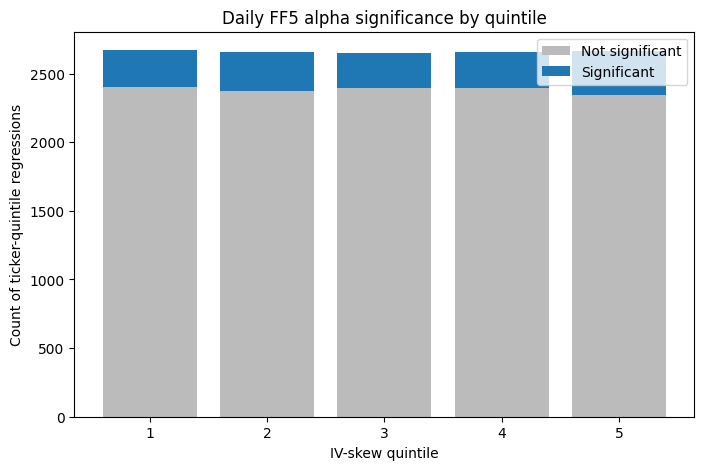

In [8]:
if not panel_results.empty:
    sig_counts = (
        panel_results
        .groupby("quintile")
        .agg(
            sig_quintiles=("alpha_sig_flag", "sum"),
            total_quintiles=("ticker", "count")
        )
        .assign(non_sig=lambda df: df["total_quintiles"] - df["sig_quintiles"])
        .reset_index()
        .sort_values("quintile")
    )

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(sig_counts["quintile"], sig_counts["non_sig"], label="Not significant", color="#bbbbbb")
    ax.bar(sig_counts["quintile"], sig_counts["sig_quintiles"], bottom=sig_counts["non_sig"],
           label="Significant", color="#1f77b4")
    ax.set_xlabel("IV-skew quintile")
    ax.set_ylabel("Count of ticker-quintile regressions")
    ax.set_title("Daily FF5 alpha significance by quintile")
    ax.legend()
    plt.show()


In [9]:
if not panel_results.empty:
    ticker_sig = (
        panel_results
        .pivot_table(index="ticker", columns="quintile", values="alpha_sig_flag", aggfunc="sum", fill_value=0)
        .astype(int)
    )
    print("Significant alpha counts per ticker/quintile:")
    display(ticker_sig.head(20))


Significant alpha counts per ticker/quintile:


quintile,1,2,3,4,5
ticker,,,,,
A,0,0,0,0,0
AA,0,0,0,0,0
AAL,0,0,0,0,0
AAN,0,0,0,0,0
AAOI,0,0,0,1,0
AAON,0,0,0,0,0
AAP,0,0,0,0,0
AAPL,0,0,0,0,0
AAWW,0,0,0,0,0
